In [216]:
# Imports and helper method
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def adjust_for_classification(outputs):
    '''
    If performing classification, we need to put our tensors into one-hot format across the full sequence.
    '''
    outputs = torch.cat(outputs, dim=0)
    # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
    outputs = outputs.transpose(0, 1).contiguous()
    outputs = nn.functional.softmax(outputs, dim=-1)
    outputs = torch.squeeze(outputs)[:, -1]
    return outputs

# Week ?? Practical Exercises

Much of the discussion can be read more thoroughly [here](https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html#fnref2), [here](https://arxiv.org/pdf/1211.5063.pdf) and [here](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).

This week will be focused on recurrent neural networks (RNNs) and long short-term memory networks (LSTMs). Whereas a traditional input for stochastic gradient descent has shape $(batch\;size, features) \in \mathbb{R}^{B \times D}$, the input to a recurrent model is a sequence. Thus, RNN inputs $x$ have shape $(batch\;size, sequence\;length, features) \in \mathbb{R}^{B \times T \times D}$.

# Recurrent Neural Networks

An RNN reads in the sequence one element at a time and maintains a hidden state $h_t \in \mathbb{R}^{B \times H}$ of information over the course of this sequence. Thus, at step $t$ in the sequence, we would have the vectors:
- $x_t \in \mathbb{R}^{B \times D}$ is the current input.
- $h_{t} \in \mathbb{R}^{B \times H}$ is the hidden step after the previous step. This represents what the model 'knows' about the sequence thus far.

The recurrent model uses both of these to process the current state of information. We proceed by:
- Concatenating $x_t$ and $h_t$ to get a 'complete' input. This represents what we already know ($h_t$) and what is new ($x_t$).
- Applying a feedforward neural network onto the concatenated 'complete' input to get a new hidden state.
- Applying a feedforward neural network onto the concatenated 'complete' input to get the output at step $t$.

When running the RNN, it will default to making a prediction at every step of the sequence.

### Questions:
- Give an example of a setting where one wants the RNN prediction from each step of the sequence.
    - Solution: For example, language generation tasks. If you just got the last prediction, you'd just get the words.
- Give an example where it one would only care about the last RNN prediction.
    - Solution: For example, classification tasks like sentiment analysis. If you want to classify text as positive or negative, you only want one prediction at the end of the text.
- Should we apply nonlinearities at any of the above steps? Which ones and why?
    - Solution: all the layers that process the hidden state should have nonlinearities. All but the last layer that process the output should have nonlinearities.

## Coding Exercise 1:
We will now implement our own RNN using the description above.

In [217]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.concat2hidden = None
        self.concat2output = None
        
        # We now instantiate the concat2hidden and concat2output linear layers
        # TIP: To instantiate a weight/bias in pytorch, use the nn.Linear() method.
        #      The function `nn.Linear(d_1, d_2)` will return a fully-connected layer
        #          that maps data from d_1 dimensions to d_2 dimensions.
        
        # Note that our nn.Linear layers will be applied onto the concatenation of the input data and the hidden state.
        
        ### YOUR CODE HERE
        self.concat2hidden = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.concat2output = nn.Linear(self.input_size + self.hidden_size, self.output_size)
        ### END CODE
    
    def init_states(self, batch_size):
        # Initialize the hidden state to be non-empty
        return nn.init.kaiming_uniform_(torch.empty(batch_size, self.hidden_size))
    
    def single_forward(self, x_t, cell_state):
        '''
        A single forward step of the RNN. We want to
            - concatenate the input and hidden state. Call this `combined`.
            - process the concatenation to a new hidden state. We want our
            - 
        '''
        combined = None
        hidden = None
        output = None
        
        # TIP: We suggest the torch.cat() function for concatenation.
        #      We want to concatenate x_t with the cell_state along the feature dimension.
        
        ### YOUR CODE HERE
        combined = torch.cat((x_t, cell_state), 1)
        hidden = torch.sigmoid(self.concat2hidden(combined))
        output = self.concat2output(combined)
        ### END CODE
        
        # Dimension checking ~~~for your convenience~~~
        assert combined.shape[0] == x_t.shape[0]
        assert combined.shape[1] == self.hidden_size + self.input_size
        assert hidden.shape[1] == self.hidden_size
        assert output.shape[1] == self.output_size
        
        return hidden, output
    
    def forward(self, x, classification=True, unsqueeze=True):
        """
        Apply the RNN to all steps in the sequence. Gather all outputs over the entire sequence.
        """
        batch_size, seq_size, _ = x.size()
        outputs = []
        hidden_state = self.init_states(batch_size)
        
        for t in range(seq_size):
            x_t = x[:, t, :]
            hidden_state, output = self.single_forward(x_t, hidden_state)
            if unsqueeze:
                output = output.unsqueeze(0)
            outputs.append(output)
        
        if classification:
            outputs = adjust_for_classification(outputs)
        return outputs

## Running the RNN

Let's see how the RNN does on a simple recurrent dataset. The airline_passengers.csv file has the number of international flights taken every month over the last decades. We will use $\frac{3}{4}$ of it for the train set and $\frac{1}{4}$ of it for the test set. The dataset has been normalized to $1$ to be easier to learn.

During training, the sequences will be $10$ months at a time and we will use a batch size of $8$. Thus, our input for the recurrent model will be $(8 \times 10 \times 1)$. The $1$ at the end is necessary since we are doing matrix multiplications at each time step. So our input at each time step has shape $(8, 1, 1)$ in order to support matrix multiplication over the batch.

The prediction will be the number of flights taken on the $11$-th month, so right after the $10$ flights were taken. As a result our target will have shape $(8 \times 1 \times 1)$. Since we are not doing matrix multiplication on the output, we simplify this and just keep the output at shape $(8)$.

In [225]:
dataset = pd.read_csv(os.path.join('data', 'airline_passengers.csv'))
dataset = dataset['Passengers'].to_numpy().astype(np.float32)
dataset /= np.max(dataset)
train_len = int(len(data) * 3 / 4)
train_set = dataset[:train_len]
test_set = dataset[train_len:]

def make_samples_from_data(dataset, input_len=10):
    """
    Given a dataset of n 1-dimensional samples, make (n - input_len) samples of shape [input_len, 1].
    """
    x, y = [], []
    for i in range(len(dataset) - input_len - 1):
        x.append(dataset[i:i+input_len])
        y.append(dataset[i+input_len])
    return torch.tensor(x), torch.tensor(y)

The dataset looks like this:

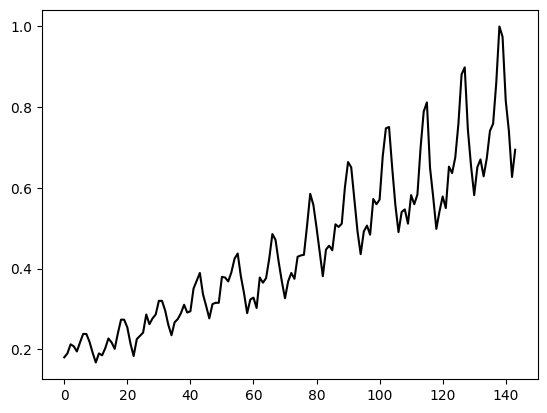

In [226]:
plt.plot(np.arange(len(dataset)), dataset, color='black')
plt.show()

We now define our training loop for this dataset. There are three questions placed within the code regarding tensor shapes.

## Questions:
1. What shape is `pred` at `QUESTION 1`?
2. What shape is `pred` at `QUESTION 2`?
3. Given the way we set up the input and output sizes, why is that the shape necessary for the loss function at  BLOCK 3`?

In [227]:
def train_airline_data(model, opt, train_x, train_y, batch_size=8, n_epochs=200):
    # Train the recurrent model to predict the number of airline passengers next month
    with tqdm(total=n_epochs) as pbar:
        pbar.set_description('Training...')
        for epoch in range(n_epochs):
            shuffle_indices = np.random.permutation(len(train_x))
            # Shuffle the data batches so that 
            train_x = train_x[shuffle_indices]
            train_y = train_y[shuffle_indices]
            for i in range(len(train_x) - batch_size - 1):
                batch_x = torch.unsqueeze(train_x[i:i+batch_size], -1)
                batch_y = train_y[i:i+batch_size]

                opt.zero_grad()
                
                pred = model(batch_x, classification=False, unsqueeze=False)
                """ QUESTION 1 --- What shape is pred right here? """
                pred = torch.squeeze(pred[-1])
                """ QUESTION 2 --- What shape is pred now? """
                """ QUESTION 3 --- Why is this the shape that is necessary for the loss calculation? """
                loss = torch.mean(torch.square(pred - batch_y))
                
                loss.backward()
                opt.step()
            
            pbar.update(1)

train_x, train_y = make_samples_from_data(train_set)
rnn_model = CustomRNN(input_size=1, hidden_size=16, output_size=1)
rnn_opt = torch.optim.SGD(rnn_model.parameters(), lr=0.1, momentum=0.9)
train_airline_data(rnn_model, rnn_opt, train_x, train_y)

Training...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.05it/s]


Let's look how the RNN does on the airline passengers dataset:

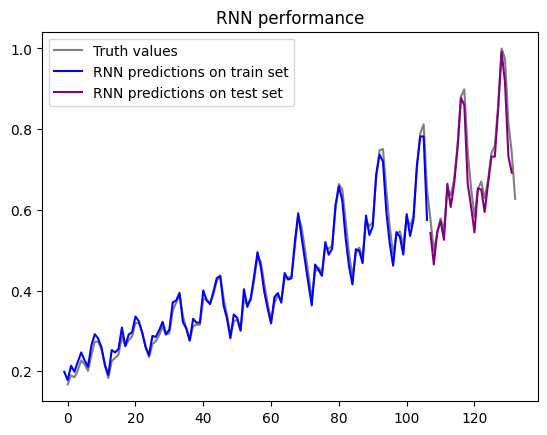

In [235]:
plt.plot(np.arange(len(full_y)), full_y, c='grey', label='Truth values')
plt.plot(np.arange(len(full_y[:train_len]))-1, rnn_preds[:train_len], c='blue', label='RNN predictions on train set')
plt.plot(np.arange(train_len, len(full_y))-1, rnn_preds[train_len:], c='purple', label='RNN predictions on test set')
plt.title('RNN performance')
plt.legend()
plt.show()

# Long Short-Term Memory Networks

The RNN has a few major issues during training such as gradient stability. To remedy this, the Long Short-Term Memory network was introduced in 1997 and popularized in the 2010s. This method maintains a sequence of gates that dictate what can be read from the memory, written to the memory, and forgotten from the memory. Using gates to specify these updates means that the model can learn to only touch the data that is relevant for its current prediction. As a result, LSTMs can learn to maintain longer-term memory dependencies.

## LSTM Framework
The LSTM framework seems complicated but can be broken down into a few straightforward parts.

There are two 'states' internal to the LSTM.
- The *cell state* is the LSTM's "memory". This is what we will choose to read and write from. When we say that the LSTM can 'read', 'write', and 'forget', it is with respect to the cell state.
- The *hidden state* serves the role of both the vanilla RNNs hidden state and its output. We receive the previous hidden state $h_t$ and current input $x_t$ as input at timestep $t$ just like the RNN does. Using these, we determine what will be forgotten in the cell state, written to the cell state, and read from the cell state. The thing that is read from the cell-state is the next 'hidden' state ($h_{t+1}$) and also acts as our output.

### Directions for assembling the LSTM
These are the IKEA instructions for putting the LSTM together in the code below. Each <ins>LSTM CODING TASK</ins> corresponds to one method in the LSTM class below.

Full set of instructions:
- We have 8 sets of weights and 4 sets of biases. This is due to having two 'inputs' ($x_t$ and the previous hidden state). The weights and biases are:
    - input to gates. These are all of shape \[input-size, hidden-size\].
        - input to input_gate. Referred to as $\text{i2i}$.
        - input to forget_gate. Referred to as $\text{i2f}$.
        - input to cell_mod. Referred to as $\text{i2c}$.
        - input to hidden_gate. Referred to as $\text{i2h}$.
    - hidden states to gates. These are all of shape \[hidden_size, hidden_size\].
        - hidden state to input_gate. Referred to as $\text{h2i}$.
        - hidden state to forget_gate. Referred to as $\text{h2f}$.
        - hidden state to cell_mod. Referred to as $\text{h2c}$.
        - hidden state to hidden_gate. Referred to as $\text{h2h}$.
    - biases. These are all of shape \[hidden_size\].
        - one bias for each gate. Referred to as $\text{ib}$, $\text{fb}$, $\text{cb}$, $\text{hb}$.

- <ins>LSTM CODING TASK 1</ins> - For each gate, we calculate its value as $x_t \cdot \text{i2_} + h_t \cdot \text{h2_} + \text{_b}$, where the blank letter is either i, f, c, or o. The $\cdot$ symbol here implies *matrix multiplication*. So, as an example, we get the input gate by $$\text{input gate} = x_t \cdot \text{i2i} + h_t \cdot \text{h2i} + \text{ib}.$$

- <ins>LSTM CODING TASK 2</ins> - We then apply nonlinearities to the gates. The input-gate, forget-gate and hidden-gate all get sigmoid activations applied onto them. The cell-mod gets a tanh applied to it.

- <ins>LSTM CODING TASK 3</ins> - We lastly calculate our new cell state and hidden state as follows:
    - $cell{\text -}state_t = forget{\text -}gate * cell{\text -}state_{t-1} + input{\text -}gate * cell{\text -}mod $
    - $hidden{\text -}state_t = output{\text -}gate * tanh(cell{\text -}state_t) $

The $*$ symbols here indicate *element-wise* multiplication. Our last-last step is to process the output with a feedforward layer (optional but useful).

### Intuition for *why* we assemble it like this
- The 8 weights and 4 biases combine information from the input and hidden state. These weights *create* the gates.
- Think of the cell-state as a set of values in a database. For each new input, we want to update this 'database' and output something. The gates are responsible for this.
- The gate purposes are as follows:
    - Cell mod: "Here is everything we could add to the cell-state".
    - Input gate: "Of all the things the cell-mod wants to add to the cell-state, here are the things that actually matter".
    - Forget gate: "Here are all the things we want to forget about the previous cell-state"
    - Output gate: "Now that we've updated our cell-state, here are all the things from it that are relevant to the output".
    
We then process the output gate by one or multiple feedforward layers. This can be interpreted as: "Given the things that were relevant from the cell-state for the output, here's what the actual prediction is at this time step."

The sigmoid activation and element-wise multiplication facilitate the above intuition. The sigmoid activation sets each gate to have values in $[0, 1]$. Thus, multiplying by this gate element-wise means we can keep anywhere from $0\%$ to $100\%$ of the information.

Now consider the gate interactions with the cell state again and see if they make sense:

- $cell{\text -}state_t = forget{\text -}gate * cell{\text -}state_{t-1} + input{\text -}gate * cell{\text -}mod $
- $hidden{\text -}state_t = output{\text -}gate * tanh(cell{\text -}state_t) $

### Intuition for *why* this works better than vanilla RNNs
We now have gates that directly control every interaction with our cell-state. Since the cell-state is directly responsible for the outputs, each gradient has to flow through the cell-state. Thus, you can think of the cell state as a highway for the gradients. Since the gates are elementwise multiplied onto the cell-state, the gradient gets scaled by the gate values. As a result, *the network can learn to only allow gradients where they are relevant*. If long-term dependencies are relevant, the network learns to prioritize them. If they aren't, it can choose to disregard them.

In [242]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # We assume our cell state is the same size as the hidden state
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Input-to-gate weights
        self.i2i = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.i2f = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.i2c = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.i2h = nn.Parameter(torch.Tensor(input_size, hidden_size))
        
        # HiddenState-to-gate weights
        self.h2i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.h2f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.h2c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.h2h = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        
        # Gate biases
        self.ib = nn.Parameter(torch.Tensor(hidden_size))
        self.fb = nn.Parameter(torch.Tensor(hidden_size))
        self.cb = nn.Parameter(torch.Tensor(hidden_size))
        self.hb = nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()
        
        self.hidden2output = nn.Linear(hidden_size, output_size)
                
    def init_weights(self):
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def init_states(self, batch_size):
        return (
            nn.init.kaiming_uniform_(torch.empty(batch_size, self.hidden_size)),
            nn.init.kaiming_uniform_(torch.empty(batch_size, self.hidden_size))
        )
    
    def get_gates(self, x_t, prev_hidden_state):
        """
        *** LSTM CODING TASK 1 ***
        Get each of the four LSTM gates based on the input, previous hidden state, and weights/biases.
        """
        input_gate, forget_gate, cell_mod, output_gate = None, None, None, None
        
        ### YOUR CODE HERE
        input_gate = x_t @ self.i2i + prev_hidden_state @ self.h2i + self.hb
        forget_gate = x_t @ self.i2f + prev_hidden_state @ self.h2f + self.fb
        cell_mod = x_t @ self.i2c + prev_hidden_state @ self.h2c + self.cb
        output_gate = x_t @ self.i2h + prev_hidden_state @ self.h2h + self.hb
        ### END CODE
        
        return input_gate, forget_gate, cell_mod, output_gate
    
    def activate_gates(self, input_gate, forget_gate, cell_mod, output_gate):
        """
        *** LSTM CODING TASK 2 ***
        Apply the relevant activations onto each of the four LSTM gates
        """
        ### YOUR CODE HERE
        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_mod = torch.tanh(cell_mod)
        output_gate = torch.sigmoid(output_gate)
        ### END CODE
        
        return input_gate, forget_gate, cell_mod, output_gate
    
    def apply_gates(
        self,
        prev_cell_state,
        prev_hidden_state,
        input_gate,
        forget_gate,
        cell_mod,
        output_gate
    ):
        """
        *** LSTM CODING TASK 3 ***
        Use the gates to update the cell state and produce the next output
        """
        
        ### First we update the cell state:
        cell_state = None
        ### YOUR CODE HERE
        # Remember to apply the tanh activation to the updated cell state
        # We want it to stay in [0, 1] so that future updates have equal impact
        cell_state = forget_gate * prev_cell_state + input_gate * cell_mod
        cell_state = torch.tanh(cell_state)
        ### END CODE
        
        ### We then use the new cell state to produce the next output:
        hidden_state = None
        ### YOUR CODE HERE
        hidden_state = output_gate * torch.tanh(cell_state)
        ### END CODE
        
        return cell_state, hidden_state
    
    def single_forward(self, x_t, prev_cell_state, prev_hidden_state):
        
        # Get all the gates given our input and previous hidden state
        input_gate, forget_gate, cell_mod, output_gate = self.get_gates(x_t, prev_hidden_state)
        
        # Apply activation functions to the gates
        input_gate, forget_gate, cell_mod, output_gate = self.activate_gates(input_gate, forget_gate, cell_mod, output_gate)
        
        # Use gates to calculate new cell state and hidden state
        cell_state, hidden_state = self.apply_gates(
            prev_cell_state,
            prev_hidden_state,
            input_gate,
            forget_gate,
            cell_mod,
            output_gate
        )
        
        output = self.hidden2output(hidden_state)
        
        return cell_state, hidden_state, output

    def forward(self, x, classification=True, unsqueeze=True):
        """ Assumes x is of shape (batch, sequence, feature) """
        batch_size, seq_size, _ = x.size()
        outputs = []
        hidden_state, cell_state = self.init_states(batch_size)
         
        for t in range(seq_size):
            x_t = x[:, t, :]
            cell_state, hidden_state, output = self.single_forward(x_t, cell_state, hidden_state)
            if unsqueeze:
                output = output.unsqueeze(0)
            outputs.append(output)
            
        if classification:
            outputs = adjust_for_classification(outputs)
        return outputs

In [243]:
train_x, train_y = make_samples_from_data(train_set)
lstm_model = CustomLSTM(input_size=1, hidden_size=16, output_size=1)
lstm_opt = torch.optim.SGD(lstm_model.parameters(), lr=0.1, momentum=0.9)
train_airline_data(lstm_model, lstm_opt, train_x, train_y, n_epochs=100)

Training...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.94it/s]


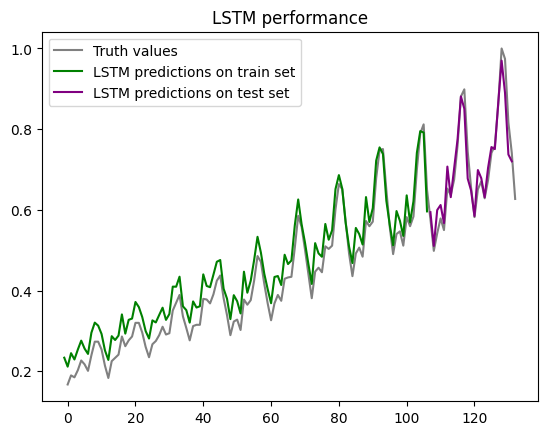

In [245]:
# Evaluate performance
full_x, full_y = make_samples_from_data(dataset)
rnn_preds, lstm_preds = [], []
for x in full_x:
    x = torch.from_numpy(np.expand_dims(np.expand_dims(x, 0), -1))
    rnn_pred = rnn_model(x, classification=False)[-1].detach().numpy()
    rnn_preds.append(np.squeeze(rnn_pred))
    
    lstm_pred = lstm_model(x, classification=False)[-1].detach().numpy()
    lstm_preds.append(np.squeeze(lstm_pred))

plt.plot(np.arange(len(full_y)), full_y, c='grey', label='Truth values')
plt.plot(np.arange(len(full_y[:train_len]))-1, lstm_preds[:train_len], c='green', label='LSTM predictions on train set')
plt.plot(np.arange(train_len, len(full_y))-1, lstm_preds[train_len:], c='purple', label='LSTM predictions on test set')
plt.title('LSTM performance')
plt.legend()
plt.show()

## The Memory-Task Dataset

We now will test the ability of our RNN and LSTM to hold long-term dependencies in their memories. To do this, we set up a simple dataset comprised of a sequence of length $L$. There is a $1$ somewhere in the first $k$ elements of the sequence and a $1$ somewhere in the last $k$ elements. We say the position of the first $1$ is at position $i$ with $0 \leq i < k$ and the second $1$ is at position $L - k + j$ with $0 \leq j < k$. Then we have $k^2$ possibilities for where the two $1$'s can be located.

Our task is to read in the sequence and predict the class value $y = k * i + j$. The question, then, is how well the different models can do this as the sequence grows.

The last parameter that we include is called `binary`. When set to true, the rest of the sequence is filled with 0's. This is the 'easy' setting. When `binary` is set to false, the rest of the sequence is populated with random values in $[0, 0.5]$.

The code to make this dataset is below:

In [270]:
def make_batch(batch_size, seq_length, k=3, binary=True):
    if seq_length < 2 * k:
        raise ValueError('Seq. Length must be greater than 2k!')
    if binary:
        data = torch.zeros((batch_size, seq_length))
    else:    
        data = torch.rand((batch_size, seq_length)) / 2

    first = torch.randint(low=0, high=k, size=(batch_size, 1))
    second = torch.randint(low=0, high=k, size=(batch_size, 1))
    
    for i in range(batch_size):
        data[i, first[i]] = 1
        data[i, seq_length - k + second[i]] = 1
        
    data = torch.unsqueeze(data, -1)
    target = (k * first + second).squeeze()
    
    return data, target

An example of the Memory-Task data can be found below. For the example, we use a batch-size of 2 and sequences of length 16. The class values are printed at the bottom. We first show an example where `binary` is set to True:

In [276]:
x, y = make_batch(2, 8, binary=True)
print('Dataset:\n', x)
print('Labels:\n', y)

Dataset:
 tensor([[[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.]],

        [[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.]]])
Labels:
 tensor([2, 7])


And here is what the Memory-Task Dataset looks like when `binary` is set to False:

In [277]:
x, y = make_batch(2, 8, binary=False)
print('Dataset:\n', x)
print('Labels:\n', y)

Dataset:
 tensor([[[1.0000],
         [0.0702],
         [0.2152],
         [0.4914],
         [0.2957],
         [1.0000],
         [0.0325],
         [0.4389]],

        [[0.2827],
         [1.0000],
         [0.2523],
         [0.0197],
         [0.3822],
         [1.0000],
         [0.2898],
         [0.1706]]])
Labels:
 tensor([0, 3])


### Training the models on the memory dataset

The code below trains an RNN and an LSTM on the memory-task dataset. We will use $k=3$ for these examples. Your task is to play around with the parameters to see whether you can answer the following questions:

- At what seq. length does the RNN break?
    - soln: around 10 when `binary=True`. Shouldn't work at all when `binary=False`.
- At what seq. length does the LSTM break?
    - soln: around 50-100 when `binary=True`. Around 10 when `binary=False`.
- How does the `binary` flag affect this? Why is it harder to learn the long-term dependencies when `binary` is set to False?
    - soln: Because an input value of 0 will be 0 after a matrix multiplication. In this sense, an input of 0 can only add to the hidden-state if the bias is non-zero. However, an input value greater than zero must be explicitly ignored. This is a task that must be 'learned' as it doesn't occur naturally. Said otherwise, it is easy to 'just' remember information and hard to also ignore irrelevant information.
- Why do you think the network easily achieves $\frac{1}{k} \sim 33\%$ accuracy but has a harder time going beyond this? Randomly guessing a class should only give $\frac{1}{k^2} \sim 11\%$ accuracy.
    - soln: The second $1$ is at the end of the sequence, close in time to where our prediction will be. Thus, it is easy to for the model to learn to ignore $\frac{k-1}{k}$ of the classes.

Tip: if the training is taking too long, feel free to decrease the `num_batches` parameter.

In [278]:
from tqdm import tqdm

# Parameters that should not be adjusted
batch_size = 8
hidden_size = 8
k = 3
num_classes = k ** 2

# Parameters to adjust
binary = True
seq_length = 20 # The sequence length must be larger than 2 * k
num_batches = 3000

# Train loop for given RNN/LSTM model
def train(model, model_name='rnn'):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    xent_loss = nn.CrossEntropyLoss()
    accs = []
    
    # We use tqdm to keep a progress bar of how many batches we've gone through during training
    with tqdm(total=num_batches) as pbar:
        pbar.set_description('Training {}...'.format(model_name))
        for batch in range(num_batches):
            # Get dataset
            data, target = make_batch(batch_size, seq_length, k=k, binary=binary)

            # Run model, get loss, backpropagate
            opt.zero_grad()
            pred = model(data)
            loss = xent_loss(pred, target)
            loss.backward()
            opt.step()
            
            # Calculate and store accuracies
            acc = (torch.argmax(pred, dim=-1) == target).sum() / batch_size
            accs.append(acc)
            
            # Update tqdm progress bar
            pbar.update(1)
            
    return accs

rnn = CustomRNN(1, hidden_size, num_classes)
rnn_accs = train(rnn, model_name='rnn')

lstm = CustomLSTM(1, hidden_size, num_classes)
lstm_accs = train(lstm, model_name='lstm')

Training lstm...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 97.03it/s]


### The below cell will plot your RNN and LSTM accuracy on the Memory-Task Data

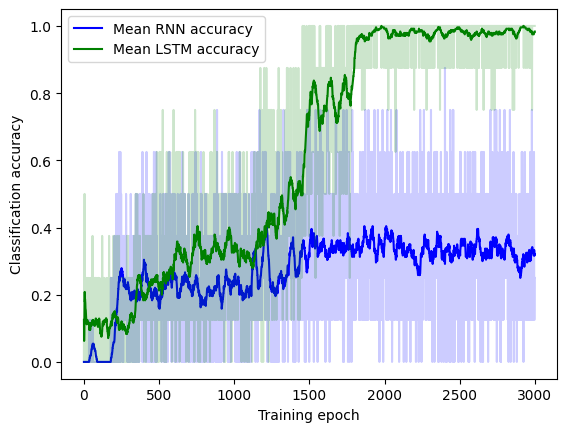

In [279]:
def running_mean(vals, steps=30):
    means = np.zeros_like(vals)
    for i, loss in enumerate(vals):
        if i < steps:
            means[i] = np.mean(vals[:i])
        else:
            means[i] = np.mean(vals[i-steps:i])
    return means

plt.plot(np.arange(num_batches), running_mean(rnn_accs), c='b', label='Mean RNN accuracy')
plt.plot(np.arange(num_batches), rnn_accs, c='b', alpha=0.2)
plt.plot(np.arange(num_batches), running_mean(lstm_accs), c='g', label='Mean LSTM accuracy')
plt.plot(np.arange(num_batches), lstm_accs, c='g', alpha=0.2)
plt.legend()
plt.xlabel('Training epoch')
plt.ylabel('Classification accuracy')
plt.show()